In [1]:
from dataclasses import dataclass

@dataclass
class ColoredPoint:
    x: float
    y: float
    black: bool

    def __lt__(self, other: "ColoredPoint") -> bool:
        return (self.x, self.y) < (other.x, other.y)

ColoredPoint(0,1,True) < ColoredPoint(0,2,True)

True

In [2]:
import numpy as np
import numpy.typing as npt

def color_points(points: npt.NDArray[np.float32], black: bool):
    return [ColoredPoint(x, y, black) for x, y in points.tolist()]

def sample_data(n: int, seed: int | None =0) -> list[ColoredPoint]:
    if seed is not None:
        np.random.seed(seed)
    all_points = np.random.uniform(-1, 1, size=(2*n, 2))
    blacks, whites = all_points[:n], all_points[n:]
    return color_points(blacks, black=True) + color_points(whites, black=False)

In [3]:
points = sample_data(n=50)

In [4]:
import matplotlib.pyplot as plt


def plot_points(points: list[ColoredPoint]):
    x_coords = [point.x for point in points]
    y_coords = [point.y for point in points]
    colors = [point.black for point in points]
    plt.scatter(x_coords, y_coords, c=colors)

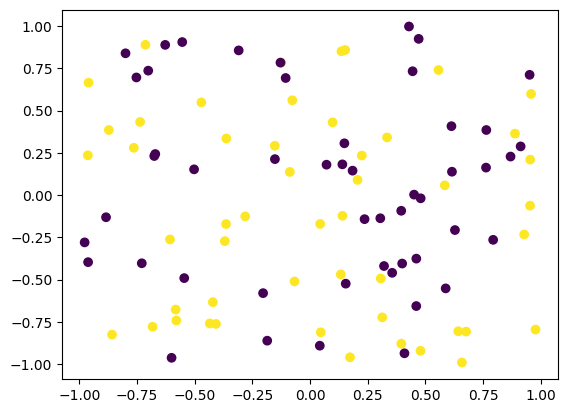

In [5]:
plot_points(points)

In [6]:
PolygonType = list[ColoredPoint]


def orientation(p: ColoredPoint, q: ColoredPoint, r: ColoredPoint) -> int:
    """Find the orientation of the ordered triplet (p, q, r)."""
    # cross product of vectors `pq` and `qr`
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0  # Collinear
    elif val > 0:
        return 1  # Clockwise
    else:
        return 2  # Counterclockwise


def jarvis_algorithm(points: list[ColoredPoint]) -> list[int]:
    """Find the convex hull using the Jarvis algorithm."""
    n = len(points)
    if n < 3:
        return list(range(n))

    # Find the leftmost point
    hull = []
    i_start = min(range(n), key=lambda i: points[i])
    i_point = i_start

    while True:
        hull.append(i_point)
        i_endpoint = 0
        for j in range(1, n):
            if (points[i_endpoint] == points[i_point]) or (
                orientation(points[i_point], points[i_endpoint], points[j]) == 1
            ):
                i_endpoint = j

        i_point = i_endpoint
        if i_point == i_start:
            break

    return hull

In [7]:
def plot_polygon(points: list[ColoredPoint]):
    points = points + [points[0]]
    x_coords = [point.x for point in points]
    y_coords = [point.y for point in points]
    plt.plot(x_coords, y_coords)

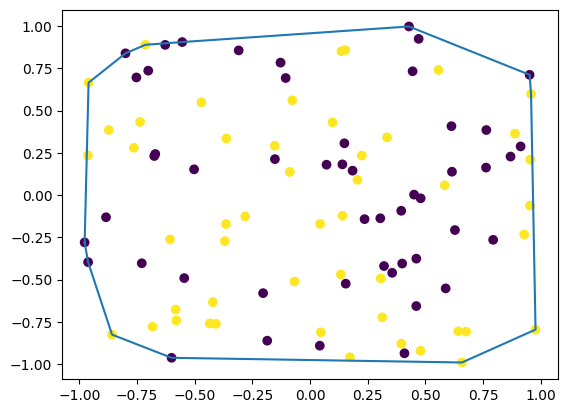

In [8]:
hull_ids = jarvis_algorithm(points)
hull_points = [points[point_id] for point_id in hull_ids]

plot_points(points)
plot_polygon(hull_points)

In [9]:
def remove_elements_by_indexes(original_list: list, indexes_to_remove: list[int]):
    indexes_to_remove.sort(reverse=True)

    for index in indexes_to_remove:
        if 0 <= index < len(original_list):
            original_list.pop(index)

    return original_list

def has_duplicates(float_list):
    return len(float_list) != len(set(float_list))

In [10]:
jarvis_algorithm(points=[ColoredPoint(0, 0, True), ColoredPoint(0, 1, False)])

[0, 1]

In [11]:
def find_closest_to_middle(lst: list[bool]) -> int | None:
    n = len(lst)
    if n == 0:
        return None

    middle = n // 2
    left = middle
    right = middle

    while left >= 0 or right < n:
        if left >= 0 and lst[left]:
            return left
        if right < n and lst[right]:
            return right
        left -= 1
        right += 1

    return None

In [12]:
from copy import deepcopy

def connect_points(points: list[ColoredPoint]) -> list[tuple[ColoredPoint, ColoredPoint]]:
    points = deepcopy(points)
    res = []  # list of tuples[point_id, point_id]
    n = len([p for p in points if p.black])
    assert n == len([p for p in points if not p.black])

    while len(points) > 0:
        hull_ids = jarvis_algorithm(points)
        if all(points[point_id].black for point_id in hull_ids) or all(not points[point_id].black for point_id in hull_ids):
            # the same color
            coords = [p.x for p in points]
            if has_duplicates(coords):
                coords = [p.y for p in points]
            left_to_right_ids = np.argsort(coords)
            black_counter = 0
            white_counter = 0
            trace = []
            for border, point_id in enumerate(left_to_right_ids):
                if points[point_id].black:
                    black_counter += 1
                else:
                    white_counter += 1
                trace.append(black_counter == white_counter)

            border = find_closest_to_middle(trace)
            if border is None:
                raise RuntimeError("something's wrong")
            left_set = [points[i] for i in left_to_right_ids[:border+1]]
            right_set = [points[i] for i in left_to_right_ids[border+1:]]
            res.extend(connect_points(left_set))
            res.extend(connect_points(right_set))
            return res
        else:
            # both blacks and whites are present in the hull
            ids_to_remove = []
            i = 0
            while i < len(hull_ids) - 1:
                a_point_id, b_point_id = hull_ids[i], hull_ids[i+1]
                if points[a_point_id].black != points[b_point_id].black:
                    # different color -> we can connect them
                    res.append((points[a_point_id], points[b_point_id]))
                    ids_to_remove.extend([a_point_id, b_point_id])
                    i += 1
                i += 1
            
            # exclude connected points
            remove_elements_by_indexes(points, ids_to_remove)
    return res
            

In [13]:
connect_points(points=[ColoredPoint(0, 0, True), ColoredPoint(0, 1, False)])

[(ColoredPoint(x=0, y=0, black=True), ColoredPoint(x=0, y=1, black=False))]

In [14]:
pairs = connect_points(points)

In [15]:
def plot_pairs(pairs: list[tuple[ColoredPoint, ColoredPoint]]):
    for a_point, b_point in pairs:
        plt.plot([a_point.x, b_point.x], [a_point.y, b_point.y])

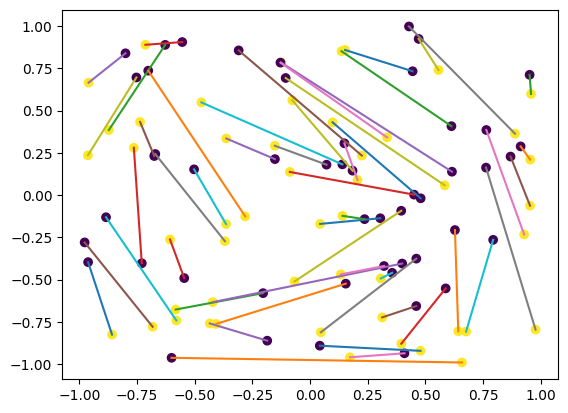

In [16]:
plot_pairs(pairs)
plot_points(points)

In [17]:
def generate_single_example(n: int):
    points = sample_data(n, seed=None)
    pairs = connect_points(points)
    plot_points(points)
    plot_pairs(pairs)
    plt.show()

In [18]:
def generate_examples(n_list: list[int]):
    for n in n_list:
        points = sample_data(n, seed=None)
        pairs = connect_points(points)
        plot_points(points)
        plot_pairs(pairs)
        plt.show()

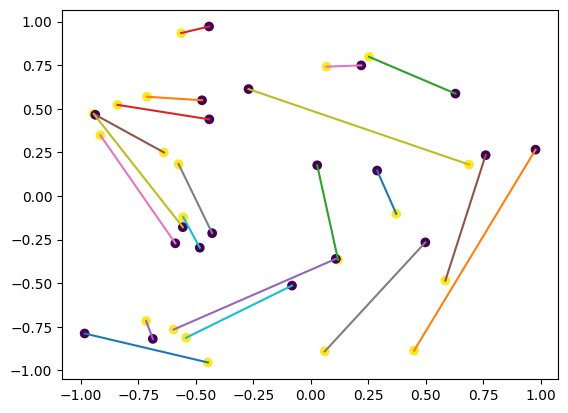

In [90]:
generate_single_example(n=20)

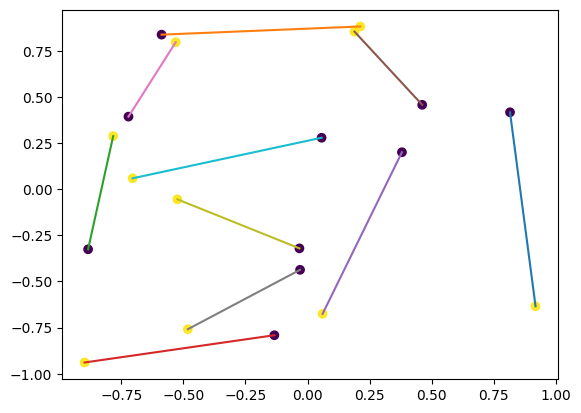

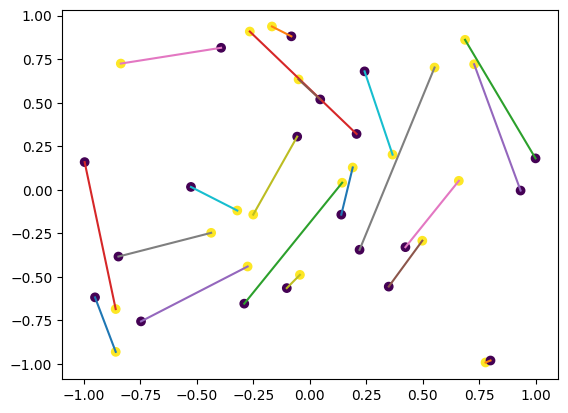

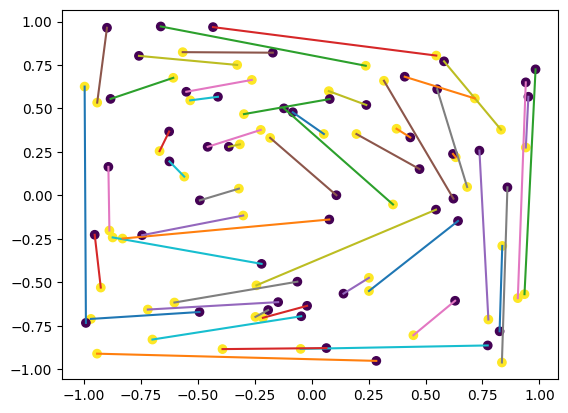

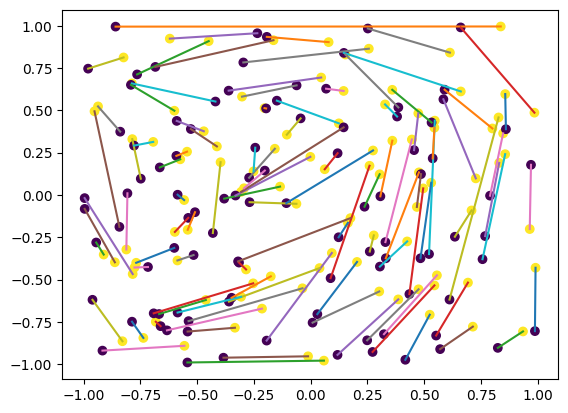

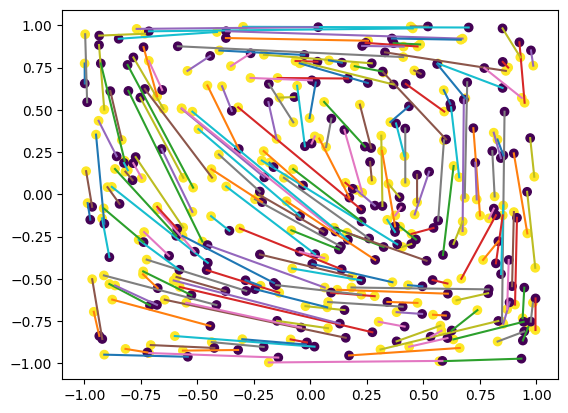

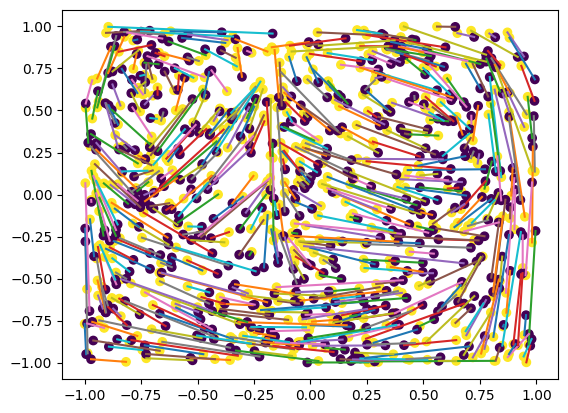

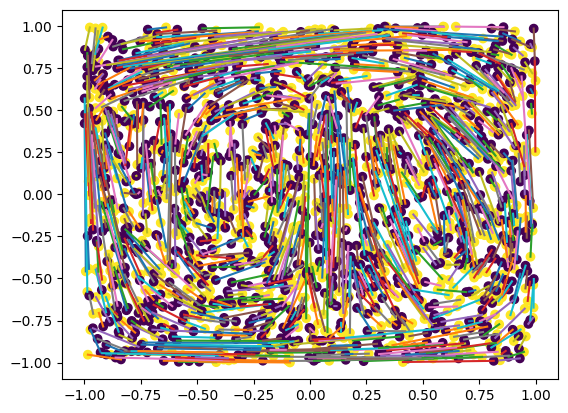

In [91]:
generate_examples(n_list=[10, 20, 50, 100, 200, 500, 1000])